# Reflexion

[Reflexion](https://arxiv.org/abs/2303.11366) by Shinn, et. al., is an architecture designed to learn through verbal feedback and self-reflection. The agent explicitly critiques its responses for tasks to generate a higher quality final response, at the expense of longer execution time.

![reflexion diagram](./img/reflexion.png)

The paper outlines 3 main components:

1. Actor (agent) with self-reflection
2. External evaluator (task-specific, e.g. code compilation steps)
3. Episodic memory that stores the reflections from (1).

In their code, the last two components are very task-specific, so in this notebook, you will build the _actor_ in LangGraph.

To skip to the graph definition, see the [Construct Graph section](#Construct-Graph) below.

## 0. Prerequisites

Install `langgraph` (for the framework), `langchain_openai` (for the LLM), and `langchain` + `tavily-python` (for the search engine).

We will use tavily search as a tool. You can get an API key [here](https://app.tavily.com/sign-in) or replace with a different tool of your choosing.

In [1]:
%pip install -U --quiet  langgraph langchain_anthropic
%pip install -U --quiet tavily-python

In [13]:
import getpass
import os


def _set_if_undefined(var: str) -> None:
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var)


# # Optional: Configure tracing to visualize and debug the agent
# _set_if_undefined("LANGCHAIN_API_KEY")
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "Reflexion"

# _set_if_undefined("ANTHROPIC_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")

In [191]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")
# You could also use OpenAI or another provider
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4-turbo-preview")

## 1. Actor (with reflection)

The main component of Reflexion is the "actor", which is an agent that reflects on its response and re-executes to improve based on self-critique. It's main sub-components include:
1. Tools/tool execution
2. Initial responder: generate an initial response (and self-reflection)
3. Revisor: re-respond (and reflec) based on previous reflections

We'll first define the tool execution context.

#### Construct tools

In [192]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_core.tools import tool

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)

#### Initial responder

In [194]:
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field, ValidationError


class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous")


class AnswerQuestion(BaseModel):
    """Answer the question. Provide an answer, reflection, and then follow up with search queries to improve the answer."""

    answer: str = Field(description="Suspicious methods in the covered.")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    search_queries: list[int] = Field(
        description="Gather method ids which are suspicious."
    )


class ResponderWithRetries:
    def __init__(self, runnable, validator):
        self.runnable = runnable
        self.validator = validator

    def respond(self, state: list):
        response = []
        for attempt in range(3):
            response = self.runnable.invoke(
                {"messages": state}, {"tags": [f"attempt:{attempt}"]}
            )
            try:
                self.validator.invoke(response)
                return response
            except ValidationError as e:
                state = state + [
                    response,
                    ToolMessage(
                        content=f"{repr(e)}\n\nPay close attention to the function schema.\n\n"
                        + self.validator.schema_json()
                        + " Respond by fixing all validation errors.",
                        tool_call_id=response.tool_calls[0]["id"],
                    ),
                ]
        return response

In [195]:
import datetime

actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are expert Tester.
Current time: {time}

1. {first_instruction}
2. Reflect and critique your answer. Be severe to maximize improvement.
3. Recommend method ids to analyze methods and improve your answer.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "\n\n<system>Reflect on the user's original question and the"
            " actions taken thus far. Respond using the {function_name} function.</reminder>",
        ),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)
initial_answer_chain = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~250 word answer.",
    function_name=AnswerQuestion.__name__,
) | llm.bind_tools(tools=[AnswerQuestion])
validator = PydanticToolsParser(tools=[AnswerQuestion])

first_responder = ResponderWithRetries(
    runnable=initial_answer_chain, validator=validator
)

In [196]:
# read a txt file and save it to a variable
with open('/Users/user/Desktop/llmfl/llama-index-test/SingleAgent/output.txt', 'r') as file:
    test_methods = file.read()

example_question = f"List 10 method ids and show in a json format like this {{methods_ids: [1,2,3,..]}} that are the most suspcious to contain the fault\n {test_methods} "
initial = first_responder.respond([HumanMessage(content=example_question)])
print(initial)

content='' additional_kwargs={'tool_calls': [{'id': 'call_59p016z2o8Cu3eTMCevJtCMI', 'function': {'arguments': '{"answer":"Based on the provided data, the most suspicious methods likely to contain the fault are method ids 1, 4, 10, 11, 15, 16, 17, 18, 19, and 21.","reflection":{"missing":"The explanation of why these specific methods are considered suspicious is lacking.","superfluous":""},"search_queries":[1,4,10,11,15,16,17,18,19,21]}', 'name': 'AnswerQuestion'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 107, 'prompt_tokens': 5812, 'total_tokens': 5919}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None} id='run-24385877-6ddc-4a4d-aeba-19b14ae86220-0' tool_calls=[{'name': 'AnswerQuestion', 'args': {'answer': 'Based on the provided data, the most suspicious methods likely to contain the fault are method ids 1, 4, 10, 11, 15, 16, 17, 18, 19, and 21.', 'reflection': {'missing': 'The explanation 

#### Revision

The second part of the actor is a revision step.

In [174]:
revise_instructions = """Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
    - You can get a method information by calling get_method_body_by_method_id with a method id number.
        - You MUST include reasoning of the code in your revised answer to ensure it can be verified.
    - You should use the previous critique to remove superfluous information from your answer.
"""


# Extend the initial answer schema to include references.
# Forcing citation in the model encourages grounded responses
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question. Provide an answer, reflection,

    call get_method_body_by_method_id with a method id int number if you need to know about a method."""

    references: int = Field(
        description="Call to get a specific method body."
    )


revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions,
    function_name=ReviseAnswer.__name__,
) | llm.bind_tools(tools=[ReviseAnswer])
revision_validator = PydanticToolsParser(tools=[ReviseAnswer])

revisor = ResponderWithRetries(runnable=revision_chain, validator=revision_validator)

In [118]:
import json

revised = revisor.respond(
    [
        HumanMessage(content=example_question),
        initial,
        ToolMessage(
            tool_call_id=initial.tool_calls[0]["id"],
            content=json.dumps(
                tavily_tool.invoke(
                    {"query": initial.tool_calls[0]["args"]["search_queries"][0]}
                )
            ),
        ),
    ]
)
revised

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_K7bt22zU5Z9AKm6AmnqOSULR', 'function': {'arguments': '{"answer":"The 10 most suspicious method ids that could contain the fault are: {methods_ids: [18, 1, 4, 5, 6, 7, 8, 9, 10, 11]}.","reflection":{"missing":"The reasoning behind the selection of these methods based on the provided information is missing, which is crucial for verification.","superfluous":"There is no need to include the JSON format in the answer as it doesn\'t add value to the identification of the suspicious methods."},"search_queries":["Reasons for identifying suspicious methods in software testing","Importance of providing reasoning for method selection in fault identification"]}', 'name': 'ReviseAnswer'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 146, 'prompt_tokens': 7208, 'total_tokens': 7354}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run

## Create Tool Node

Next, create a node to execute the tool calls. While we give the LLMs different schema names (and use those for validation), we want them both to route to the same tool.

In [188]:
from langchain_core.tools import StructuredTool

from langgraph.prebuilt import ToolNode


import json
from langchain_core.tools import tool

file_path = '/Users/user/Desktop/llmfl/llama-index-test/data/Gson/processed_by_depgraph_withoutline/18/test_0.json'

with open(file_path, 'r') as file:
    data = json.load(file)


# # @tool
# def get_covered_methods_by_failedTest() -> list:
#     """Returns the covered methods by a failed test."""
#     covered_methods = data['covered_methods']
#     return covered_methods[:100]


def get_method_body_by_method_id(method_id: list[int], **kwargs):
    """
    Takes method_id list as parameter and returns the method_body as string list
    """
    methods = []
    for id in method_id:
        for method in data['covered_methods']:
            if method['method_id'] == id:
                methods.append(method['method_body'])

    return methods


def get_test_body_stacktrace() -> list:
    """Returns the test body and stack trace"""
    test_body = data['test_body']
    stacktrace = data['stack_trace']
    return [test_body, stacktrace]


def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    return tavily_tool.batch([{"query": query} for query in search_queries])


# tool_node = ToolNode(
#     [
#         StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
#         StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
#     ]
# )

tool_node = ToolNode(
    [
        StructuredTool.from_function(get_test_body_stacktrace, name=AnswerQuestion.__name__),
        StructuredTool.from_function(get_method_body_by_method_id, name=ReviseAnswer.__name__, description="pass a method id to get the method body")
    ]
)

## Construct Graph


Now we can wire all our components together.

In [189]:
from typing import Literal

from langgraph.graph import END, MessageGraph, START

MAX_ITERATIONS = 5
builder = MessageGraph()
builder.add_node("draft", first_responder.respond)


builder.add_node("execute_tools", tool_node)
builder.add_node("revise", revisor.respond)
# draft -> execute_tools
builder.add_edge("draft", "execute_tools")
# execute_tools -> revise
builder.add_edge("execute_tools", "revise")

# Define looping logic:


def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i


def event_loop(state: list) -> Literal["execute_tools", "__end__"]:
    # in our case, we'll just stop after N plans
    num_iterations = _get_num_iterations(state)
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"


# revise -> execute_tools OR end
builder.add_conditional_edges("revise", event_loop)
builder.add_edge(START, "draft")
graph = builder.compile()

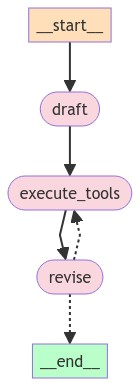

In [23]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [190]:
# read a txt file and save it to a variable
with open('/Users/user/Desktop/llmfl/llama-index-test/SingleAgent/output.txt', 'r') as file:
    test_methods = file.read()

events = graph.stream(
    [HumanMessage(content=f"List method ids and show in a json format like this {{methods_ids: [1,2,3,..]}} that are the most suspcious to contain the fault\n {test_methods}")],
    stream_mode="values",
)
for i, step in enumerate(events):
    print(f"Step {i}")
    step[-1].pretty_print()

Step 0
================================ Human Message =================================

List 10 method ids and show in a json format like this {methods_ids: [1,2,3,..]} that are the most suspcious to contain the fault
 {
    "bug_id": 18,
    "test_id": 0,
    "test_name": "com.google.gson.functional.CollectionTest.testIssue1107",
    "test_body": "public void testIssue1107() {\nString json = \"{\\n\" +\n\"  \\\"inBig\\\": {\\n\" +\n\"    \\\"key\\\": [\\n\" +\n\"      { \\\"inSmall\\\": \\\"hello\\\" }\\n\" +\n\"    ]\\n\" +\n\"  }\\n\" +\n\"}\";\nBigClass bigClass = new Gson().fromJson(json, BigClass.class);\nSmallClass small = bigClass.inBig.get(\"key\").get(0);\nassertNotNull(small);",
    "stack_trace": "java.lang.ClassCastException: com.google.gson.internal.LinkedTreeMap cannot be cast to com.google.gson.functional.CollectionTest$SmallClass\nat com.google.gson.functional.CollectionTest.testIssue1107(CollectionTest.java:410)",
    "covered_methods": [
        {
            "metho

ValidationError: 1 validation error for ReviseAnswerSchema
method_id
  field required (type=value_error.missing)

## Conclusion

Congrats on building a Reflexion actor! I'll leave you with a few observations to save you some time when choosing which parts of this agent to adapt to your workflow:
1. This agent trades off execution time for quality. It explicitly forces the agent to critique and revise the output over several steps, which usually (not always) increases the response quality but takes much longer to return a final answer
2. The 'reflections' can be paired with additional external feedback (such as validators), to further guide the actor.
3. In the paper, 1 environment (AlfWorld) uses external memory. It does this by storing summaries of the reflections to an external store and using them in subsequent trials/invocations.